# Trend Classification on Green Energy Stocks
# With Trends Data

### Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import warnings
warnings.simplefilter("ignore")

from indicators import *
from data_loading import *
from util_functions import *


physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


### Parameters

In [2]:
trail_size=14
predict_length = 5
time_period = '6y'

# 1.0 Load data

## 1.1 Load stock data

In [3]:
top_energy = ["XOM", "CVX", "RDS-A", "RDS-B", "PTR", "TOT", "BP",
"SNP", "ENB", "COP", "EQNR", "PBR-A", "PBR", "EPD",
"TRP", "E", "EOG", "SLB", "KMI", "PSX", "CNQ",
"MPC", "PXD", "SU", "VLO"]

In [4]:
traditional_energy_stocks = [ "LNG", "OKE", "BKR", "WMB", "EQT",  "XEC",  "XOM",  "CVX",  "BP",  "OXY",  "COP",  "EOG",  "COG",  "CNQ",  "SLB",  "PTR",  "TOT",  "ENB"]

In [5]:
green_energy_stocks = ["CSIQ", "SPWR", "AQN.TO", "DQ", "HYSR", "PLUG", "SOL", "NEE", "ENPH", "FSLR", "SEDG", "ORA", ]

In [6]:
data = get_data_yf(green_energy_stocks + top_energy, time_period)

[*********************100%***********************]  37 of 37 completed


In [7]:
data.isna().sum().sum()

4830

In [8]:
sum(data.isna().sum(axis=1)>0)

56

In [9]:
data = data.dropna()

In [10]:
sum(data.isna().sum(axis=1)>0)

0

In [11]:
data = process_stock_data_from_yf(data)

In [12]:
has_data_ratio, data = filter_has_all_data(data)
has_data_ratio

100.0

## 1.2 Compute technical indicators

In [13]:
all_stock_features = ['Close', 'High',
 'Low', 'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 'WMA', 'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 'DX',
 'PDI', 'NDI', 'ADX',
 'ROC', 'MACD', 'CCI']

In [14]:
# compute all our technical markers for each of the stocks. 
dataset = data.groupby('Ticker').apply(lambda x: add_technical_markers(x, trail_size))

## 1.3 Load trends data

In [15]:
filenames = [os.path.join("data", x) for x in [
    "data climate change adjusted.csv",
    "data greenhouse gas adjusted.csv",
    "data oil adjusted.csv",
    "data renewable adjusted.csv",
    "data carbon tax adjusted.csv",
    "data electric vehicles adjusted.csv",
    "data environmental protection agency adjusted.csv",
    "data fossil fuels adjusted.csv",
    "data fracking adjusted.csv",
    "data global warming adjusted.csv",
] ]
terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
    "environmental protection agency",
    "fossil fuels",
    "fracking",
    "global warming",
]

In [16]:
climate_trends_data = load_climate_data(filenames, terms)

In [17]:
climate_trends_data.shape

(2278, 11)

<AxesSubplot:xlabel='Date'>

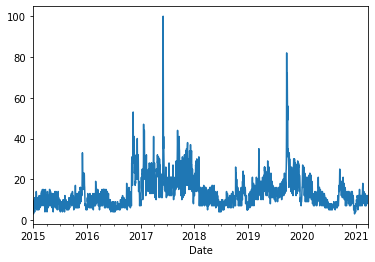

In [18]:
climate_trends_data.set_index('Date')[terms[0]].plot()

### Choose features

In [19]:
chosen_stock_features = ['Close', 'High',
 'Low', 
'Open', 'Volume',
 'HH', 'LL', 'AV',
 'SMA', 'SD', 
#'WILLR',
 'ATR', 'DMH', 'DML',
 'EMA', 
'WMA', 
'BBHIGH',
 'BBLOW', 'PERBHIGH', 'PERBLOW',
 'TRIMA', 'RSI', 
#'DX',
 'PDI', 'NDI', 
'ADX',
 'ROC', 'MACD', 'CCI'
                        ]
# DX and WILLR can cause issues when stock prices don't change, results in lots of nan. 

In [20]:
chosen_trend_terms = [
    "climate change",
    "greenhouse gas",
    "oil",
    "renewable",
    "carbon tax",
    "electric vehicles",
#     "environmental protection agency",
    "fossil fuels",
#     "fracking",
    "global warming",
]

# 2.0 Model design

In [21]:
num_features = len(chosen_stock_features) + len(chosen_trend_terms) 

In [22]:
reg = 0.002
drop=0.25

model = Sequential()
model.add(LSTM(units=75, input_shape=(trail_size, num_features), return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))
model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(LSTM(units=30, return_sequences=True, activity_regularizer=l2(reg)))
model.add(Dropout(drop))

model.add(Flatten())

model.add(Dense(5, activation='relu', activity_regularizer=l2(reg)))
model.add(Dropout(drop))


model.add(Dense(1, activation='sigmoid'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 75)            33300     
_________________________________________________________________
dropout (Dropout)            (None, 14, 75)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14, 30)            12720     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14, 30)            7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 14, 30)            7

# 3.0 Prepare dataset of many stocks

In [24]:
h = dataset.loc[dataset['Ticker']=='HYSR']

In [25]:
h.isna().sum()

Ticker        0
Date          0
Close         0
High          0
Low           0
Open          0
Volume        0
HH            0
LL            0
AV            0
SMA           0
SD            1
WILLR       268
ATR           0
DMH           0
DML           0
EMA           0
WMA          13
BBHIGH        1
BBLOW         1
PERBHIGH      1
PERBLOW       1
TRIMA        13
RSI          14
DX          621
PDI           0
NDI           0
ADX           6
ROC           0
MACD          0
CCI           1
dtype: int64

In [26]:
# h[h.isna().sum(axis=1)>0][:100]

In [27]:
# dataset[dataset.isna().sum(axis=1)>0]

In [28]:
x_train, y_train, x_valid, y_valid, x_test, y_test = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks + top_energy,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [29]:
print("x_train: {}".format(x_train.shape))
print("y_train: {}".format(y_train.shape))
print("x_valid: {}".format(x_valid.shape))
print("y_valid {}".format(y_valid.shape))
print("x_test: {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train: (25351, 14, 35)
y_train: (25351,)
x_valid: (8399, 14, 35)
y_valid (8399,)
x_test: (8436, 14, 35)
y_test (8436,)


## 3.1 Train on many stocks

In [30]:
time_stamp = time()
tensorboard = TensorBoard(log_dir='logs/{}'.format(time_stamp))

In [31]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [32]:
history1 = model.fit(x_train, 
                     y_train, 
                     epochs=15, 
                     validation_data=(x_valid, y_valid), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
397/397 [==============================] - 14s 23ms/step - loss: 0.7519 - accuracy: 0.5104 - val_loss: 0.6946 - val_accuracy: 0.5190
Epoch 2/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6876 - accuracy: 0.5449 - val_loss: 0.7067 - val_accuracy: 0.5730
Epoch 3/15
397/397 [==============================] - 6s 16ms/step - loss: 0.6858 - accuracy: 0.5505 - val_loss: 0.6938 - val_accuracy: 0.5099
Epoch 4/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6827 - accuracy: 0.5618 - val_loss: 0.6987 - val_accuracy: 0.5520
Epoch 5/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6785 - accuracy: 0.5690 - val_loss: 0.7012 - val_accuracy: 0.5224
Epoch 6/15
397/397 [==============================] - 6s 15ms/step - loss: 0.6760 - accuracy: 0.5751 - val_loss: 0.7034 - val_accuracy: 0.5317
Epoch 7/15
397/397 [==============================] - 6s 16ms/step - loss: 0.6701 - accuracy: 0.5880 - val_loss: 0.7332 - val_accuracy: 0.525

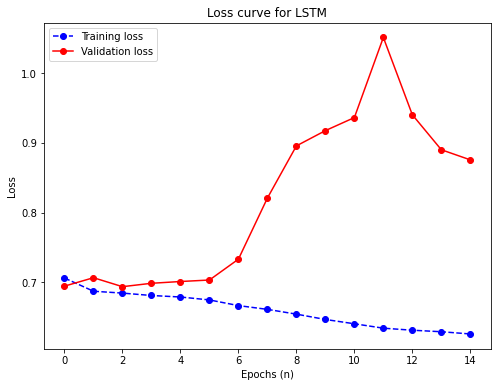

In [33]:
plot_loss(history1)

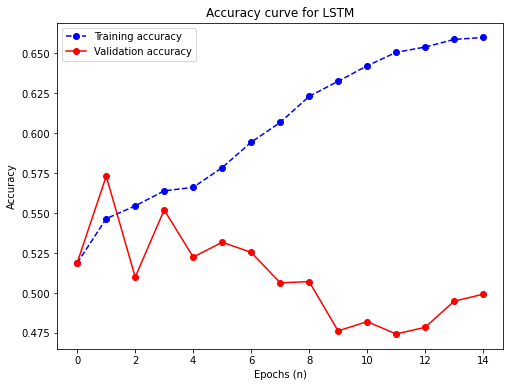

In [34]:
plot_acc(history1)

## 3.2 Performance of model

In [35]:
performance_stats(model, x_train, y_train)

Upward ratio: 50.34%
Mean prediction: 49.74%
Predicted upward ratio: 53.37%
Accuracy: 68.17%


In [36]:
performance_stats(model, x_valid, y_valid)

Upward ratio: 51.70%
Mean prediction: 40.59%
Predicted upward ratio: 36.53%
Accuracy: 49.92%


In [37]:
performance_stats(model, x_test, y_test)

Upward ratio: 50.26%
Mean prediction: 55.22%
Predicted upward ratio: 62.99%
Accuracy: 52.37%


# 4.0 Prepare data for less stocks

In [38]:
x_train2, y_train2, x_valid2, y_valid2, x_test2, y_test2 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           green_energy_stocks,
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [39]:
print("x_train: {}".format(x_train2.shape))
print("y_train: {}".format(y_train2.shape))
print("x_valid: {}".format(x_valid2.shape))
print("y_valid {}".format(y_valid2.shape))
print("x_test: {}".format(x_test2.shape))
print("y_test {}".format(y_test2.shape))

x_train: (8201, 14, 35)
y_train: (8201,)
x_valid: (2724, 14, 35)
y_valid (2724,)
x_test: (2736, 14, 35)
y_test (2736,)


## 4.1 Train model on less stocks

In [40]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [41]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
tensorboard = TensorBoard(log_dir='logs/{}_2'.format(time_stamp))

In [43]:
history2 = model.fit(x_train2, 
                     y_train2, 
                     epochs=15, 
                     validation_data=(x_valid2, y_valid2), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/15
129/129 [==============================] - 12s 58ms/step - loss: 0.6528 - accuracy: 0.6229 - val_loss: 0.7798 - val_accuracy: 0.5198
Epoch 2/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6472 - accuracy: 0.6342 - val_loss: 0.7852 - val_accuracy: 0.5264
Epoch 3/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6443 - accuracy: 0.6411 - val_loss: 0.8186 - val_accuracy: 0.5217
Epoch 4/15
129/129 [==============================] - 2s 15ms/step - loss: 0.6381 - accuracy: 0.6441 - val_loss: 0.7808 - val_accuracy: 0.5345
Epoch 5/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6451 - accuracy: 0.6350 - val_loss: 0.8430 - val_accuracy: 0.5176
Epoch 6/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6403 - accuracy: 0.6403 - val_loss: 0.8331 - val_accuracy: 0.5206
Epoch 7/15
129/129 [==============================] - 2s 16ms/step - loss: 0.6313 - accuracy: 0.6477 - val_loss: 0.8283 - val_accuracy: 0.510

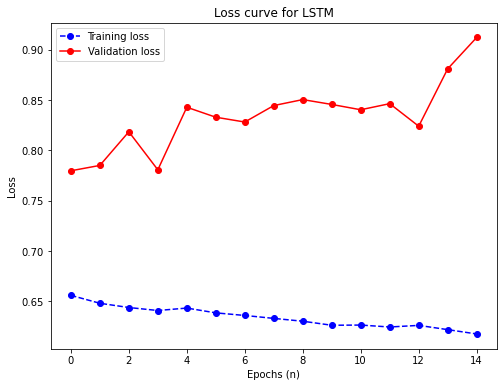

In [44]:
plot_loss(history2)

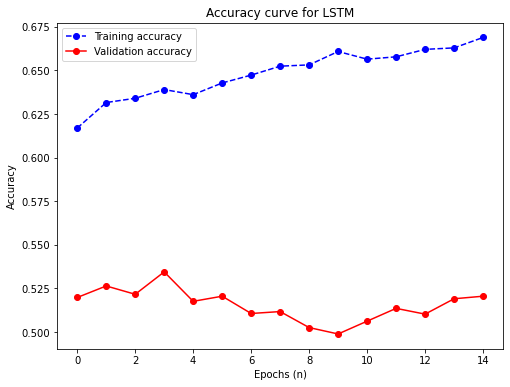

In [45]:
plot_acc(history2)

## 4.2 Performance of model

In [46]:
performance_stats(model, x_train2, y_train2)

Upward ratio: 47.60%
Mean prediction: 46.17%
Predicted upward ratio: 39.71%
Accuracy: 68.65%


In [47]:
performance_stats(model, x_valid2, y_valid2)

Upward ratio: 48.46%
Mean prediction: 45.69%
Predicted upward ratio: 28.78%
Accuracy: 52.06%


In [48]:
performance_stats(model, x_test2, y_test2)

Upward ratio: 55.23%
Mean prediction: 62.46%
Predicted upward ratio: 62.61%
Accuracy: 50.58%


Text(0.5, 1.0, 'Testing confusion matrix')

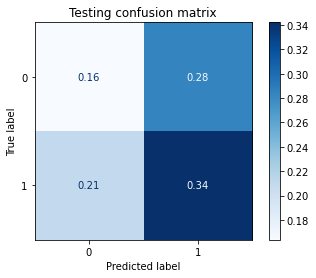

In [49]:
cm = confusion_matrix(y_true=y_test2, 
                      y_pred=model.predict(x_test2)>0.5,
                     normalize="all")

ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Testing confusion matrix")

In [50]:
print(classification_report(y_true = y_test2,
                     y_pred = model.predict(x_test2)>0.5))

              precision    recall  f1-score   support

           0       0.44      0.37      0.40      1225
           1       0.55      0.62      0.58      1511

    accuracy                           0.51      2736
   macro avg       0.49      0.49      0.49      2736
weighted avg       0.50      0.51      0.50      2736



# 5.0 Prepare data for one stock

In [51]:
green_energy_stocks[0]

'CSIQ'

In [52]:
x_train3, y_train3, x_valid3, y_valid3, x_test3, y_test3 = generate_dataset(dataset, 
                                                                           climate_trends_data,
                                                                           [green_energy_stocks[0]],
                                                                           "2018-03-01", "2019-03-01", "2020-03-01", 
                                                                           chosen_stock_features, chosen_trend_terms,
                                                                            trail_size, predict_length
                                                                           )

In [53]:
print("x_train: {}".format(x_train3.shape))
print("y_train: {}".format(y_train3.shape))
print("x_valid: {}".format(x_valid3.shape))
print("y_valid {}".format(y_valid3.shape))
print("x_test: {}".format(x_test3.shape))
print("y_test {}".format(y_test3.shape))

x_train: (686, 14, 35)
y_train: (686,)
x_valid: (227, 14, 35)
y_valid (227,)
x_test: (228, 14, 35)
y_test (228,)


## 5.1 Train model on one stock

In [54]:
# model.layers[7].trainable = False
# model.layers[4].trainable = False
# model.layers[2].trainable = False
# model.layers[0].trainable = False

In [55]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [56]:
tensorboard = TensorBoard(log_dir='logs/{}_3'.format(time_stamp))

In [57]:
history3 = model.fit(x_train3, 
                     y_train3, 
                     epochs=5, 
                     validation_data=(x_valid3, y_valid3), 
                     batch_size=64, 
                     shuffle=True, 
                     callbacks=[tensorboard])

Epoch 1/5
11/11 [==============================] - 11s 631ms/step - loss: 0.5759 - accuracy: 0.7336 - val_loss: 0.9081 - val_accuracy: 0.5066
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.5363 - accuracy: 0.7563 - val_loss: 1.0632 - val_accuracy: 0.5198
Epoch 3/5
11/11 [==============================] - 0s 18ms/step - loss: 0.5306 - accuracy: 0.7791 - val_loss: 1.1365 - val_accuracy: 0.5198
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.5053 - accuracy: 0.7674 - val_loss: 1.0951 - val_accuracy: 0.4934
Epoch 5/5
11/11 [==============================] - 0s 18ms/step - loss: 0.4833 - accuracy: 0.7832 - val_loss: 1.0677 - val_accuracy: 0.4802


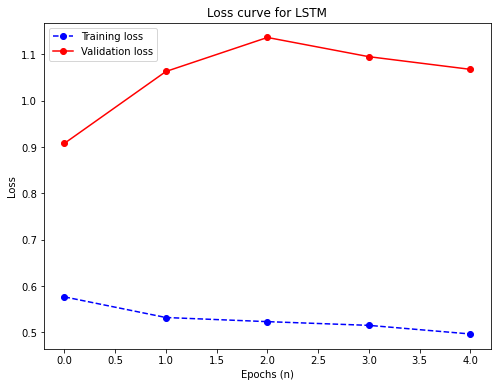

In [58]:
plot_loss(history3)

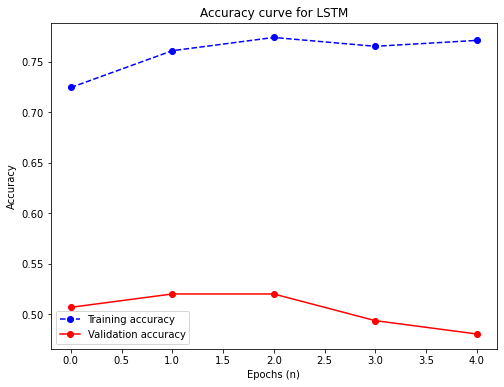

In [59]:
plot_acc(history3)

## 5.2 Performance of model

In [60]:
performance_stats(model, x_train3, y_train3)

Upward ratio: 50.29%
Mean prediction: 49.03%
Predicted upward ratio: 48.10%
Accuracy: 84.11%


In [61]:
performance_stats(model, x_valid3, y_valid3)

Upward ratio: 56.83%
Mean prediction: 44.80%
Predicted upward ratio: 34.80%
Accuracy: 48.02%


In [62]:
performance_stats(model, x_test3, y_test3)

Upward ratio: 54.82%
Mean prediction: 65.90%
Predicted upward ratio: 66.23%
Accuracy: 56.14%


Text(0.5, 1.0, 'Testing confusion matrix')

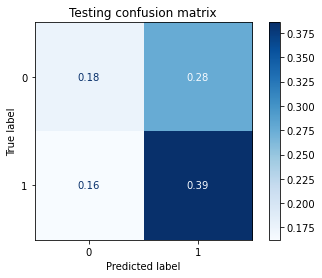

In [63]:
cm = confusion_matrix(y_true=y_test3, 
                      y_pred=model.predict(x_test3 )>0.5,
                     normalize="all")

ConfusionMatrixDisplay(cm).plot(cmap="Blues")
plt.title("Testing confusion matrix")

In [64]:
print(classification_report(y_true = y_test3,
                     y_pred = model.predict(x_test3)>0.5))

              precision    recall  f1-score   support

           0       0.52      0.39      0.44       103
           1       0.58      0.70      0.64       125

    accuracy                           0.56       228
   macro avg       0.55      0.55      0.54       228
weighted avg       0.55      0.56      0.55       228

